# Electroencephalogram (EEG) and alcohol


## **EEG**
#### **What is EEG ?**
An electroencephalogram (EEG) is a test that records the brain's electrical activity noninvasively through electrodes placed on the scalp. The procedure involves placing these electrodes that are connected by wires to a computer, which then records and analyzes the electrical impulses in the brain. EEG is used for diagnosing and managing brain-related disorders like epilepsy, monitoring brain activity during surgeries, and conducting neuroscience research.

EEG patterns, consisting of different waves, are analyzed to understand normal or abnormal brain function. The procedure is safe, though preparation is required, and it might be slightly uncomfortable. EEG primarily detects activity in the brain's cortex with limited spatial resolution and can be affected by various factors like age and medication. Unlike MRI and CT scans that visualize brain structure, EEG captures real-time activity, making it a valuable tool in neuroscience and medicine.
<br><br>
#### **What does an EEG help diagnose?**

EEG is used primarily to diagnose conditions that affect brain activity. It’s particularly useful in identifying epilepsy and other seizure disorders by capturing the electrical activity of the brain. Besides, EEG can also help diagnose or manage other conditions like sleep disorders, depth of anesthesia, coma, encephalopathies, brain death, and certain psychiatric disorders. It is often used in conjunction with other diagnostic tools to provide comprehensive insights into brain health and function.
<br><br>

#### **What factors can influence the results of an EEG?**

Various factors can influence EEG results. Medications (such as sedatives, anti-epileptic drugs) can alter electrical activity in the brain, affecting the test's findings. The patient's age and overall brain development can also play a role in the results. The physical and mental state of the patient during the test, like being stressed, relaxed, asleep, or awake, can also influence the brain's electrical activity. External interference from electronic devices and not following preparatory instructions (like washing hair to ensure good electrode contact) can also impact the data quality and test outcomes.
<br><br>
#### **How reliable is EEG in diagnosing various brain disorders?**

EEG is a reliable tool for diagnosing disorders related to abnormal brain activity, like epilepsy. However, its reliability can be influenced by the technician's skill, the patient's cooperation, and the above-mentioned factors that might affect the results. While EEG provides valuable real-time data on brain function, it might not catch intermittent or infrequent abnormalities in brain activity if they don't occur during the test. Therefore, it's often used alongside other diagnostic methods, like MRI or CT scans, to provide a more complete picture of brain health and accurate diagnosis.


## **Brain and Alcohol**
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6668890/ searched deeper for Alcoholism and Human Electrophysiology.

Interestingly, the article suggests that the observed electrical abnormalities in the brains of alcoholics might not be a result of alcohol consumption per se, but rather a pre-existing condition, possibly serving as a risk marker for alcoholism. Some of these electrical characteristics, such as increased resting beta power and decreased active theta oscillations during cognitive tasks, have also been identified in individuals at high risk for developing alcoholism, even before any exposure to alcohol. Therefore, the text proposes that an inherent imbalance in CNS excitation and inhibition might predispose individuals to alcoholism. This imbalance is suggested to not only contribute to the risk of developing alcoholism but might also offer insights into the neurobiology of craving and relapse in alcoholism

## Dataset

In [1]:
%%sh
wget -q https://archive.ics.uci.edu/static/public/121/eeg+database.zip 
unzip -q eeg+database.zip 

gunzip -k eeg_full/*.gz
for file in eeg_full/*.tar; do tar -xf $file -C eeg_full; done
gunzip -k eeg_full/*/*.gz
rm eeg_full/*.tar.gz eeg_full/*.tar eeg_full/*/*.gz
[ -e train ] || mkdir train
[ -e test ] || mkdir test

In [2]:
! echo 'file_name' > eeg_full.csv
! find eeg_full -type f -exec bash -c '[[ $(wc -l < "$1") -gt 4 ]]' _ {} \; -print >> eeg_full.csv

In [3]:
!pip install -q -U mne

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import mne
import os

from tqdm import tqdm
import torch
from torch.utils.data import Dataset
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
def extract_raw_data(file):
    with open(file) as f:
        lines = f.readlines()

        data = []
        channel_names = []
        is_Alcolic = lines[0][5] == 'a'
        id_patient = int(lines[0][6:13])


        if(len(lines)<=3):
          return None,None,None

        l3 = lines[3].split()
        obj = l3[1]
        trial = int(lines[4].split()[-1])


        for line in lines[4:]:
          line_split = line.split()

          if (not line.startswith('#')):
            values = line_split[-1]
            data.append(values)
          else :
            ch_name = line_split[1]
            channel_names.append(ch_name)

        data = np.array(data, dtype="float").reshape((64, -1)) * 1e-6
        info = {"his_id" : id_patient,  "is_Alcolic" : is_Alcolic,'id': id_patient,
                "trial": trial, "obj": obj}
        return data, channel_names, info

In [6]:
def save_raw_files(file, save=False, train=True):
    file_name = file.split("/")[-1].replace(".", "_") + "_eeg"

    data, ch_names, info_patient = extract_raw_data(file)
    if(data is None):
        return None
    info = mne.create_info(ch_names=ch_names, sfreq=256, ch_types='eeg')
    raw = mne.io.RawArray(data=data, info=info, verbose=False)
    raw.info['subject_info'] = info_patient
    if (save):
        dir = "train" if train else "test"
        raw.save(f"{dir}/{file_name}.fif", overwrite=True, verbose=False)
    return raw

In [7]:
def save_all(current_dir):
    for dir_name, subdirs, files in tqdm(list(os.walk(current_dir))):
        for file_name in files[1:]:
              if ((".rd.") in file_name):
                current_file = os.path.join(dir_name, file_name)
                #train = "TRAIN" in current_file
                save_raw_files(current_file, save=True)
save_all('.')

100%|██████████| 126/126 [08:48<00:00,  4.19s/it]


Create two directroies which which will contain data as csv.

In [8]:
! [ -e train_csv ] || mkdir train_csv
! [ -e test_csv ] || mkdir test_csv

Generate a dataframe from an eeg file.

In [9]:

def generate_df(file,save=False,train=True,verbose=False,frequency = 256):
  df = pd.DataFrame()
  data, channel_names, info = extract_raw_data(file)
  file_name = file.split("/")[-1]
  for time_series,channel in zip(data, channel_names):
    time = np.arange(0,time_series.shape[-1])*1/time_series.shape[-1]
    cur_df = pd.DataFrame({'value':time_series,'channel':channel,**info,'time':time})
    if(df is None):
      df = cur_df
    else:
      df = pd.concat([df,cur_df],ignore_index=True)
  if(save):
    dir = "train" if train else "test"
    saving_path = f'{dir}_csv/{file_name}.csv'
    df.to_csv(saving_path)
  return df

In [10]:
def generated_csv(content_dir:str='/content/',train=True):
    for dir_name, subdirs, files in tqdm(list(os.walk(content_dir))):
        for file_name in (files):
            current_file = os.path.join(dir_name, file_name)
            regex = r'.+\.rd\.\d+$'
            if (re.match(regex,file_name)):
                generate_df(current_file,save=True,train=train)

In [11]:
# for data_dir,train in zip(['SMNI_CMI_TRAIN','SMNI_CMI_TEST'],[True,False]):
#  generated_csv(data_dir,train)

Opening raw data file train/co2a0000439_rd_041_eeg.fif...
Isotrak not found
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
Using matplotlib as 2D backend.


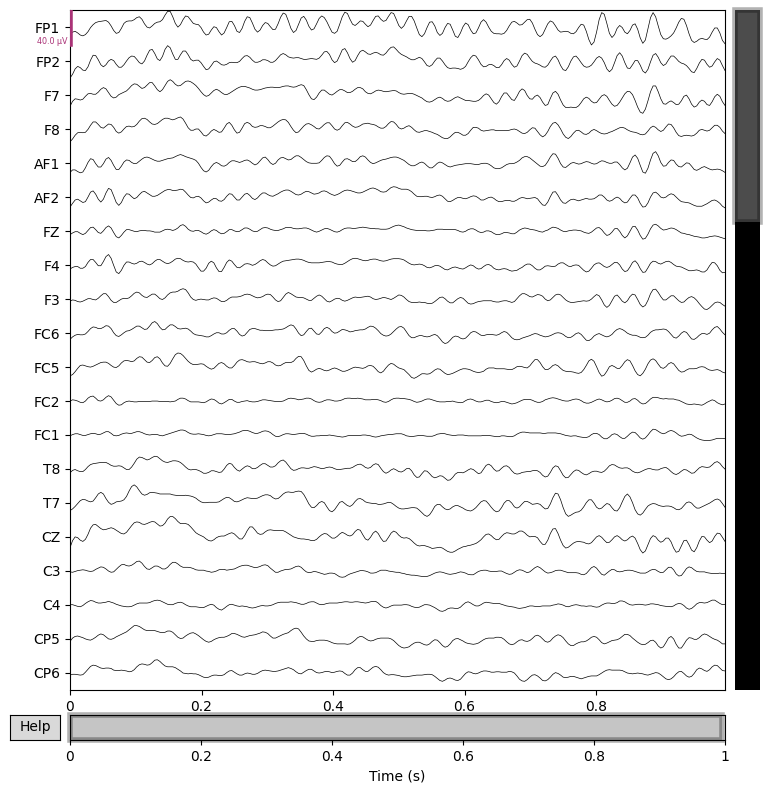

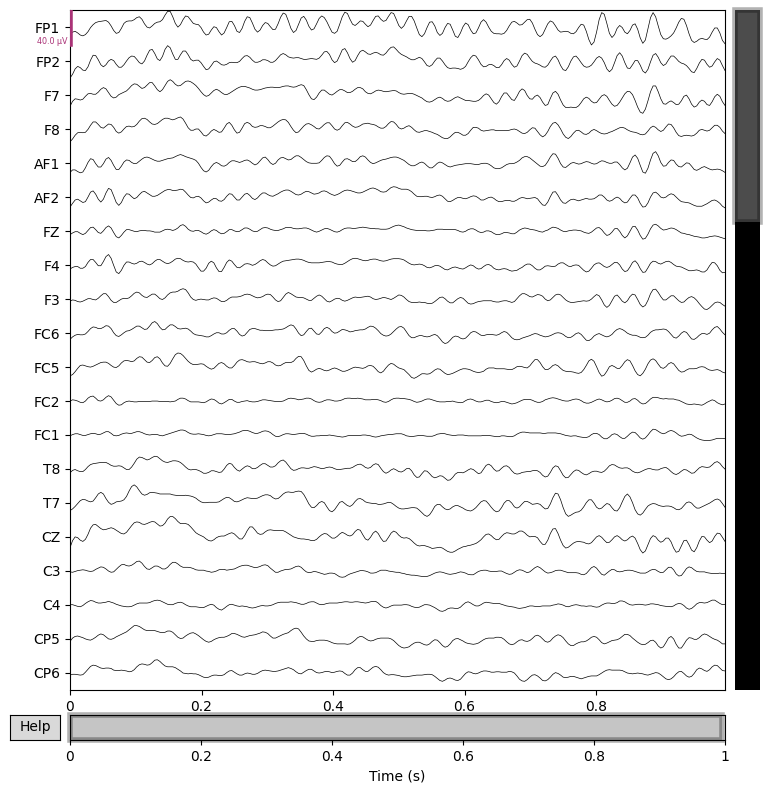

In [12]:
content = list(os.walk('train'))
# print(content)
raw = mne.io.read_raw(f"{content[0][0]}/{content[0][2][0]}")
raw.plot()

In [13]:
raw.get_data()

array([[ 1.69899999e-06,  4.13999987e-06,  5.11700000e-06, ...,
         3.16399996e-06, -5.62500009e-06, -9.53200015e-06],
       [-5.17799981e-06, -7.83000019e-07,  5.56399982e-06, ...,
         1.58179992e-05,  9.47100034e-06,  3.61100001e-06],
       [-5.82900020e-06,  3.09999990e-08,  2.96000007e-06, ...,
         5.89000001e-06, -4.57999988e-07, -4.85200007e-06],
       ...,
       [ 1.73000004e-07,  1.73000004e-07,  6.61000001e-07, ...,
         1.14900001e-06,  1.14900001e-06,  1.14900001e-06],
       [-3.96699988e-06, -1.52600001e-06, -2.01400007e-06, ...,
         3.35699997e-06, -6.10000015e-08, -1.52600001e-06],
       [-3.59100000e-06, -1.14900001e-06, -1.63799996e-06, ...,
         3.73300009e-06, -1.73000004e-07, -1.63799996e-06]])

In [14]:
from scipy.stats import skew, kurtosis

def extract_features(data):
    features_names = []
    features = []
    for i, channel_data in enumerate(data):
        mean = np.mean(channel_data)
        var = np.var(channel_data)
        skewness = skew(channel_data)
        kurt = kurtosis(channel_data)
        channel_features = [mean, var, skewness, kurt]
        channel_names = ['mean', 'var', 'skewness', 'kurt']

        features.extend(channel_features)
        features_names.extend(list(map(lambda x : x + f"_{i}", channel_names)))

    return features, features_names

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
def create_df(directory):
    df_data = []
    features_names =[]
    for dir, subdir, files in tqdm(list(os.walk(directory))):
        for f in files[1:]:
            data, ch_names, info= extract_raw_data(f"./{dir}/{f}")
            if(data is None):
                continue
            features, features_names = extract_features(data)
            features.extend([info['obj'], info['is_Alcolic']])
            df_data.append(features)
            features_names.extend(['obj', 'alcoholic'])
    return pd.DataFrame(df_data, columns=features_names)

full_df = create_df("eeg_full")
df_train, df_test = train_test_split(full_df, test_size=0.2, random_state=42)
df_train.head()

100%|██████████| 123/123 [04:43<00:00,  2.30s/it]


,mean_0,var_0,skewness_0,kurt_0,mean_1,var_1,skewness_1,kurt_1,mean_2,var_2,...,mean_62,var_62,skewness_62,kurt_62,mean_63,var_63,skewness_63,kurt_63,obj,alcoholic
8693,0.000005,3.763213e-10,-0.665437,1.637424,0.000002,2.944668e-10,-0.304918,0.722287,6.285379e-06,1.770855e-10,...,1.450984e-05,2.087632e-10,0.503575,-0.033208,1.449905e-05,2.074666e-10,0.488939,-0.044621,S1,False
7719,-0.000001,4.529443e-11,-0.703252,-0.156568,-0.000003,4.956231e-11,-0.730696,-0.012482,2.835937e-07,2.938518e-11,...,-6.274844e-07,3.483869e-11,0.012125,-0.402669,-5.785820e-07,3.758023e-11,0.034945,-0.391419,S2,True
5798,-0.000001,3.356938e-11,0.728831,-0.025073,-0.000002,5.017769e-11,0.461345,0.227763,-5.812312e-06,4.327584e-11,...,-1.108680e-05,8.218326e-11,0.408229,-0.863556,-1.142311e-05,8.729152e-11,0.405678,-0.868012,S2,True
7853,0.000003,2.139756e-11,0.730426,0.493979,0.000008,2.125242e-11,0.203823,-0.629580,2.436926e-06,3.398502e-11,...,-1.183195e-06,4.067618e-11,0.376301,-0.357612,-9.943437e-07,4.327653e-11,0.353286,-0.307783,S2,True
5165,0.000006,1.918014e-11,-0.133712,-0.409903,0.000007,2.412722e-11,-0.519320,0.984850,1.070633e-06,4.733793e-11,...,6.355910e-06,3.797156e-11,-0.539649,0.688588,7.490789e-06,9.010904e-11,0.292545,-0.246525,S1,True


In [17]:
def preprocess(df):
    dummies = pd.get_dummies(df['obj'])
    df = df.drop(columns="obj")
    df = pd.concat([df, dummies], axis=1)
    df['alcoholic'] = df['alcoholic'].replace({True: 1, False: 0}).astype(int)

    return df.dropna()

df_train = preprocess(df_train)
df_test = preprocess(df_test)
df_train.head()

,mean_0,var_0,skewness_0,kurt_0,mean_1,var_1,skewness_1,kurt_1,mean_2,var_2,...,var_62,skewness_62,kurt_62,mean_63,var_63,skewness_63,kurt_63,alcoholic,S1,S2
8693,0.000005,3.763213e-10,-0.665437,1.637424,0.000002,2.944668e-10,-0.304918,0.722287,6.285379e-06,1.770855e-10,...,2.087632e-10,0.503575,-0.033208,1.449905e-05,2.074666e-10,0.488939,-0.044621,0,True,False
7719,-0.000001,4.529443e-11,-0.703252,-0.156568,-0.000003,4.956231e-11,-0.730696,-0.012482,2.835937e-07,2.938518e-11,...,3.483869e-11,0.012125,-0.402669,-5.785820e-07,3.758023e-11,0.034945,-0.391419,1,False,True
5798,-0.000001,3.356938e-11,0.728831,-0.025073,-0.000002,5.017769e-11,0.461345,0.227763,-5.812312e-06,4.327584e-11,...,8.218326e-11,0.408229,-0.863556,-1.142311e-05,8.729152e-11,0.405678,-0.868012,1,False,True
7853,0.000003,2.139756e-11,0.730426,0.493979,0.000008,2.125242e-11,0.203823,-0.629580,2.436926e-06,3.398502e-11,...,4.067618e-11,0.376301,-0.357612,-9.943437e-07,4.327653e-11,0.353286,-0.307783,1,False,True
5165,0.000006,1.918014e-11,-0.133712,-0.409903,0.000007,2.412722e-11,-0.519320,0.984850,1.070633e-06,4.733793e-11,...,3.797156e-11,-0.539649,0.688588,7.490789e-06,9.010904e-11,0.292545,-0.246525,1,True,False


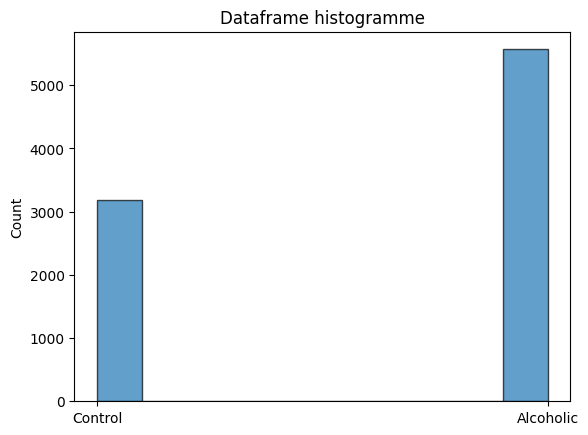

In [18]:
plt.hist(df_train['alcoholic'], alpha=0.7, edgecolor="k")
plt.title("Dataframe histogramme")
plt.ylabel("Count")
plt.xticks([0, 1], ['Control', 'Alcoholic'])
plt.show()

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(df_train)
scaled = scaler.transform(df_train)
scaled_test = scaler.transform(df_test )

df_train_scaled = pd.DataFrame(scaled, columns=df_train.columns)
df_test_scaled = pd.DataFrame(scaled, columns=df_train.columns)
df_train_scaled.head()

,mean_0,var_0,skewness_0,kurt_0,mean_1,var_1,skewness_1,kurt_1,mean_2,var_2,...,var_62,skewness_62,kurt_62,mean_63,var_63,skewness_63,kurt_63,alcoholic,S1,S2
0,0.521518,0.013563,0.211825,0.130596,0.513616,0.013112,0.299170,0.110258,0.692569,0.009804,...,0.009012,0.589250,0.049370,0.643199,0.009018,0.580457,0.129014,0.0,1.0,0.0
1,0.480985,0.001632,0.206718,0.080075,0.482503,0.002207,0.242566,0.088493,0.681495,0.001627,...,0.001504,0.538095,0.043222,0.537442,0.001634,0.526209,0.113875,1.0,0.0,1.0
2,0.481103,0.001210,0.400102,0.083778,0.483770,0.002234,0.401041,0.095609,0.670248,0.002396,...,0.003548,0.579325,0.035552,0.461376,0.003794,0.570508,0.093070,1.0,0.0,1.0
3,0.506018,0.000771,0.400317,0.098395,0.554234,0.000946,0.366805,0.070214,0.685468,0.001882,...,0.001756,0.576002,0.043971,0.534526,0.001881,0.564247,0.117526,1.0,0.0,1.0
4,0.528859,0.000691,0.283627,0.072941,0.547998,0.001074,0.270667,0.118035,0.682947,0.002621,...,0.001639,0.480661,0.061381,0.594042,0.003917,0.556989,0.120200,1.0,1.0,0.0


In [20]:
from sklearn.svm import SVR

X_train, y_train = df_train_scaled.loc[:, df_train_scaled.columns != 'alcoholic'], df_train_scaled['alcoholic']
X_test, y_test = df_test_scaled.loc[:, df_test_scaled.columns != 'alcoholic'], df_test_scaled['alcoholic']
regr = SVR(C=1.0, epsilon=0.2)
regr.fit(X_train, y_train)

SVR(epsilon=0.2)

In [21]:
from sklearn.metrics import accuracy_score

accuracy_score(regr.predict(X_test).astype(int), y_test.astype(int))

0.3735711019661637

In [22]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [23]:
class EEGDataset(Dataset):
    def __init__(self,eeg_dir:str,eeg_files:str):
        # generate X = ( eeg: 64x256 , s_type : 2x1)
        # generate y = ()
        self.eeg_dir = eeg_dir
        self.eeg_files = pd.read_csv(eeg_files)
        self.s_objects = ['S1','S2']
        self.s_object_table = {s_object: i for i,s_object in enumerate(self.s_objects)}
        self.num_objects = len(self.s_objects )


    def __getitem__(self, idx):

        file_name = self.eeg_files['file_name'][idx]
        data, _, info= extract_raw_data(file_name)
        if(data is None or info is None):
            return None
        object_vector = np.zeros(self.num_objects)
        obj_idx = self.s_object_table[info['obj']]
        object_vector[obj_idx] = 1
        object_tensor = torch.tensor(object_vector).to(DEVICE)

        alcoholic = torch.zeros(2,dtype=float).to(DEVICE)

        alcoholic[int(info['is_Alcolic'])] = 1
        tensor_data = torch.tensor(data).to(DEVICE)

        return (tensor_data,object_tensor),alcoholic

    def __len__(self):
        return len(self.eeg_files)

In [24]:
eeg_ds = EEGDataset('eeg_full','eeg_full.csv')

train_size = int(0.8 * len(eeg_ds))
test_size = len(eeg_ds) - train_size

train_ds,test_ds  = torch.utils.data.random_split(eeg_ds,[train_size,test_size])

train_dataloader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size=64, shuffle=True)

In [25]:
class EEG_NN(nn.Module):
    def __init__(self):
      super(EEG_NN,self).__init__()

      self.conv1 = nn.Conv2d(1,64,3,dtype=torch.double)
      self.relu1 = nn.ReLU()
      self.maxpool1 = nn.MaxPool2d((2,2))

      self.conv2 = nn.Conv2d(64,32,3,dtype=torch.double)
      self.relu2 = nn.ReLU()
      self.maxpool2 = nn.MaxPool2d((2,2))

      self.conv3 = nn.Conv2d(32,16,3,dtype=torch.double)
      self.relu3 = nn.ReLU()
      self.maxpool3 = nn.MaxPool2d((2,2))

      self.flatten = nn.Flatten(1)
      self.lin1 = nn.Linear(2882,64,dtype=torch.double)
      self.lin2 = nn.Linear(64,2,dtype=torch.double)
      self.check_cuda()
    def check_cuda(self):
        if(torch.cuda.is_available()):
            print('CUDA seems to be available')
            self.to(DEVICE)

    def forward(self, x):
        x1,x2 = x
        x1 = x1.unsqueeze(1)
        # print(x1.size())
        x1 = self.conv1(x1)
        x1 = self.relu1(x1)
        x1 = self.maxpool1(x1)

        x1 = self.conv2(x1)
        x1 = self.relu2(x1)
        x1 = self.maxpool2(x1)

        x1 = self.conv3(x1)
        x1 = self.relu3(x1)
        x1 = self.maxpool3(x1)

        x1 = self.flatten(x1)
        x1 = torch.cat((x1,x2),dim=1)
        x1 = self.lin1(x1)
        x1 = self.lin2(x1)
        x1 = nn.Sigmoid()(x1)
        return x1




Checking good input and output shape.

In [26]:
def compute_num_correct_pred(y_prob:torch.tensor, y_label:torch.tensor):
    y_pred = (y_prob >= 0.5).float()

    correct_predictions = torch.all(y_pred == y_label,dim=1).sum()
    return int(correct_predictions)

In [27]:
eeg_model = EEG_NN()
x,y = next(iter(train_dataloader))
out = eeg_model(x)
print(compute_num_correct_pred(out,y))
out.size(), out.is_cuda

CUDA seems to be available
39


(torch.Size([64, 2]), True)

In [28]:
def train_model(model,train_loader,optimizer,loss_func):
    model.train()

    for x,y in tqdm(train_loader):
        out = model(x)
        loss = loss_func(out,y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [29]:
def test(loader,net,verbose=False):
    net.eval()
    correct = 0
    with torch.no_grad():
        for x,y in tqdm(loader):
            out = net(x)
            correct += compute_num_correct_pred(out, y)
    if(verbose):
        print(f'{correct} prediction on {len(loader.dataset)} samples')
    return correct / len(loader.dataset)

In [30]:
def full_train(model,train_loader,test_loader,optimizer,loss_func,n_epochs,verbose=False):
    train_accs = []
    test_accs = []
    for i in range(n_epochs):
        train_model(model,train_loader,optimizer,loss_func)
        train_acc = test(train_loader,model)
        if(verbose):
              print(f'Train accuracy {train_acc:.2f}')

        test_acc =test(test_loader,model)
        if(verbose):
              print(f'Test accuracy {test_acc:.2f}')

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        history_df = pd.DataFrame({'train_accuracy':train_accs,'test_accuracy':test_accs})
        history_df.to_csv(('history.csv'))
    return history_df

In [31]:
eeg_model = EEG_NN()
learning_rate = 0.001
optimizer = torch.optim.SGD(eeg_model.parameters(), lr=learning_rate)
loss_func = nn.BCELoss()
history_df = full_train(eeg_model,train_loader=train_dataloader,test_loader=test_dataloader,optimizer=optimizer,loss_func=loss_func,n_epochs=15)

CUDA seems to be available


100%|██████████| 35/35 [00:24<00:00,  1.42it/s]
